# Phase 2 - Data preprocessing
### Authors: Karolina Skrypova(50%), Oleh Fedunchyk(50%)

## Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, ClassifierMixin
from sklearn.metrics import accuracy_score, precision_score, recall_score

## Loading the data

In [2]:
# connections_data = pd.read_csv('https://raw.githubusercontent.com/myrres0/IAU-2024/main/dataset-120/connections.csv', sep='\t')
# processes_data = pd.read_csv('https://raw.githubusercontent.com/myrres0/IAU-2024/main/dataset-120/processes.csv', sep='\t')
connections_data = pd.read_csv('dataset-120/connections.csv', sep='\t')
processes_data = pd.read_csv('dataset-120/processes.csv', sep='\t')

## Datasets for processing

Our constants:

In [3]:
selected_attributes = [
    "mwra",
    "p.android.externalstorage",
    "p.android.settings",
    "p.android.gm",
    "p.system",
    "p.android.packageinstaller",
    "c.android.gm",
    "c.android.youtube",
    "p.android.chrome",
    "c.android.chrome"
]

In [4]:
def divide_df(df):
    mwra = df['mwra']
    df_ = df.drop('mwra', axis=1)
    return train_test_split(df_, mwra, test_size=0.2, random_state=42)

In [5]:
merged_data = pd.merge(processes_data, connections_data).drop_duplicates()
train_data, test_data = train_test_split(merged_data[selected_attributes], test_size=0.25)
mwra_train = pd.DataFrame(train_data.pop('mwra'))
mwra_test = pd.DataFrame(test_data.pop('mwra'))

In [6]:
mwra_train.head()

,mwra
3250,1.0
14538,1.0
6720,1.0
11483,1.0
11739,1.0


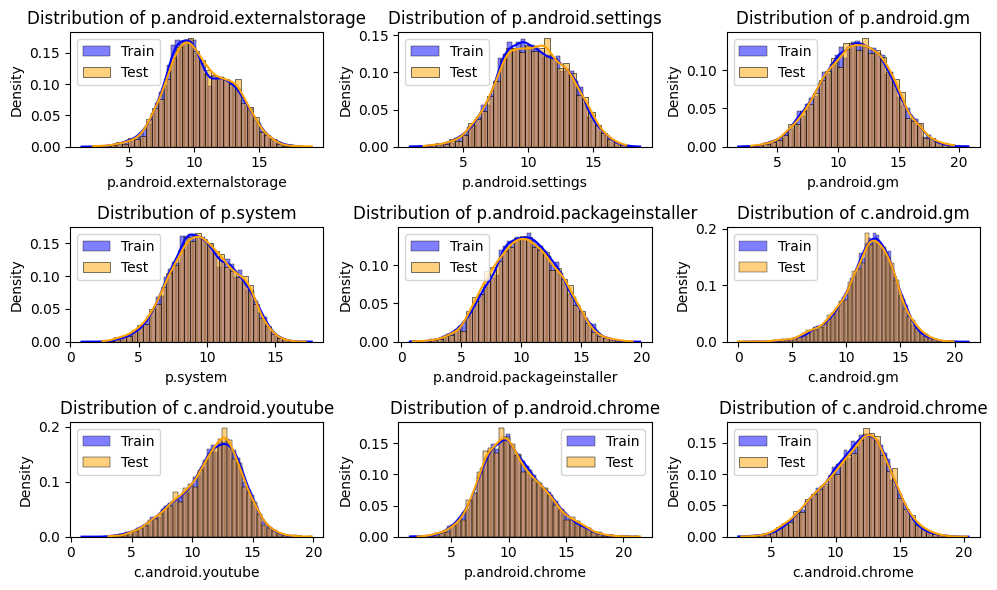

In [7]:
num_columns = 3
num_rows = 3
fig, axes = plt.subplots(num_rows, num_columns, figsize=(10, num_rows * 2))
axes = axes.flatten()

for idx, column in enumerate(train_data.columns):
    sns.histplot(train_data[column], color='blue', label='Train', kde=True, stat="density", ax=axes[idx])
    sns.histplot(test_data[column], color='orange', label='Test', kde=True, stat="density", ax=axes[idx])
    axes[idx].set_title(f'Distribution of {column}')
    axes[idx].legend()

plt.tight_layout()
plt.show()

## Data pre-processing pipeline

### Data cleaning

In [8]:
class Cleaner(TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_ = X.apply(self.resolve_missing_values)
        return X_.apply(self.transform_outliers)

    # we do not have NA values in our dataset, but let this step be in our pipeline
    def resolve_missing_values(self, column):
        return column.fillna(column.median())

    # we have checked mrwa have no outliers so can also be proceeded by this function
    def transform_outliers(self, column):
      Q1 = column.quantile(0.25)
      Q3 = column.quantile(0.75)
      IQR = Q3 - Q1
      lower_bound = Q1 - 1.5 * IQR
      upper_bound = Q3 + 1.5 * IQR

      outliers = column[(column < lower_bound) | (column > upper_bound)]
      cleaned_column = column.clip(lower=lower_bound, upper=upper_bound)

      return cleaned_column

### Data transforming

In [9]:
class Transformer(TransformerMixin):
    def __init__(self):
        self.power_transformer = PowerTransformer(method='yeo-johnson', standardize=True)

    def fit(self, X, y=None):
        self.power_transformer.fit(X)
        return self

    def transform(self, X):
        return pd.DataFrame(self.power_transformer.transform(X), columns=X.columns)

### Data scaling

In [10]:
class Scaler(TransformerMixin):
    def __init__(self):
        self.standard_scaler = MinMaxScaler()

    def fit(self, X, y=None):
        self.standard_scaler.fit(X)
        return self

    def transform(self, X):
        return pd.DataFrame(self.standard_scaler.transform(X), columns=X.columns)

### Pipeline

In [11]:
pipeline = Pipeline([
    ('cleaner', Cleaner()),
    ('transformer', Transformer()),
    ('scaler', Scaler())
]).fit(train_data, mwra_train)

In [12]:
train_data_transformed = pipeline.transform(train_data)
test_data_transformed = pipeline.transform(test_data)

## 3.1 Simple ID3 classifier based on dependencies in the data

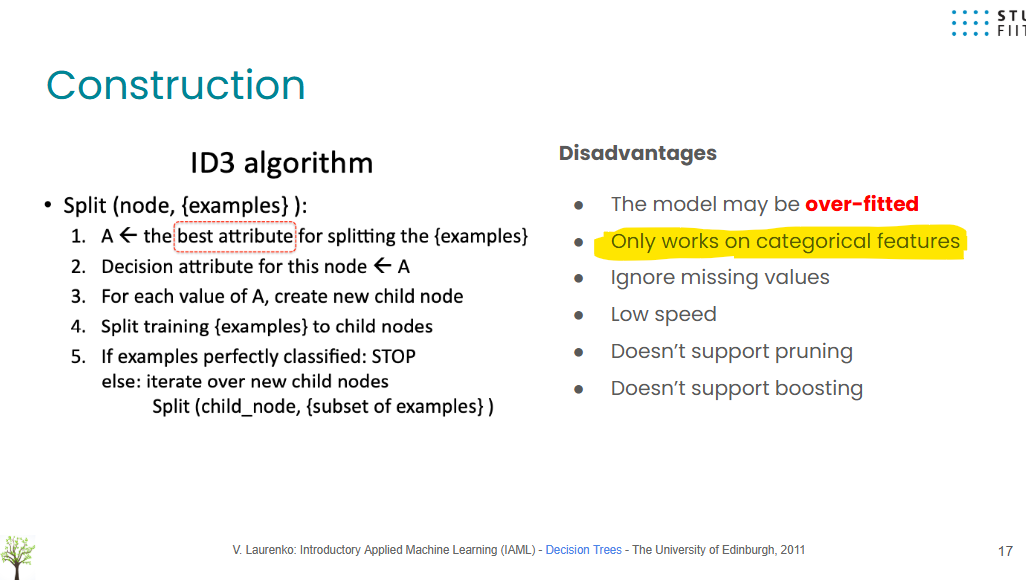

In [13]:
class ClassifierID3(ClassifierMixin):

    class TreeNode:
        def __init__(self, dataset, depth, attribute=None, interval_lower_bound=None, interval_upper_bound=None):
            self.dataset = dataset
            self.depth = depth
            self.attribute = attribute
            self.interval_lower_bound = interval_lower_bound
            self.interval_upper_bound = interval_upper_bound
            self.children = []
            self.predicted_value = None  # only for leaf nodes

        def is_leaf(self):
            return self.predicted_value is not None


    def __init__(self, intervals_number=None, max_depth=None):
        if max_depth is not None and max_depth <= 2:
            raise ValueError("Min depth must be at least 2.")

        if  intervals_number is None or intervals_number < 2:
            raise ValueError("Intervals number must be at least 2.")

        self.max_depth = max_depth
        self.intervals_number = intervals_number
        self.target_attribute = None
        self.tree = None

    def fit(self, X, y):
        # Combine the features (X) and target (y) into one DataFrame
        X = X.reset_index(drop=True)
        y = y.reset_index(drop=True)

        X['index'] = X.index
        y['index'] = y.index

        # Now merge the DataFrames using the common column 'index'
        data = pd.merge(X, y, on='index')

        data = data.drop(columns=['index'])

        self.target_attribute = y.columns[0]

        # Building the tree
        root = self.TreeNode(data, 0)
        self.tree = self._build_tree(root)

        return self


    def _build_tree(self, node):

        # print("----------------------------------------------------------------------------------------")
        # print("-----  ", node.depth, "  -------")
        # print("-----  ", node.dataset.shape[0], "  -------")
        # print("-----  ", node.dataset.columns, "  -------")
        # print(node.dataset.head(10))

        # Calculate the frequency of ea(ch class label (target attribute)
        target_counts = node.dataset[self.target_attribute].value_counts()

        # print("-----  ", len(target_counts), "  -------")


        # If all labels are the same, return a leaf node
        if len(target_counts) == 1:
            node.predicted_value = target_counts.index[0]
            return node

        # If max depth is reached or dataset has 1 attribute, create a leaf node with the most frequent class
        if node.depth == self.max_depth or len(node.dataset.columns) == 1:
            node.predicted_value = target_counts.idxmax()
            return node

        # Find the best attribute to split on
        best_attribute = self._get_best_attribute_for_split(node.dataset)
        node.attribute = best_attribute
        # print(best_attribute)

        # Split the data based on the chosen attribute into intervals
        intervals = self._get_intervals(node.dataset[best_attribute])

        # creating children
        interval_lower_bound = intervals[0]
        for interval_upper_bound in intervals[1:]:
            # Create a child node for the current interval
            child_data = self._get_dataset_in_interval(node.dataset, best_attribute, interval_lower_bound, interval_upper_bound).drop(best_attribute, axis=1)

            if not child_data.empty:
                child_node = self.TreeNode(dataset=child_data, depth=node.depth + 1, interval_lower_bound=interval_lower_bound, interval_upper_bound=interval_upper_bound)
                node.children.append(child_node)

            interval_lower_bound = interval_upper_bound

        # recursion
        for child in node.children:
            self._build_tree(child)

        return node


    def _get_best_attribute_for_split(self, dataset):
        """
        Calculate the Information Gain for all attributes and return the best one.
        """
        best_info_gain = -np.inf
        best_attribute = None

        # Check each feature (excluding the target attribute)
        for attribute in dataset.columns:
            if attribute != self.target_attribute:
                info_gain = self._information_gain(dataset, attribute)
                if info_gain > best_info_gain:
                    best_info_gain = info_gain
                    best_attribute = attribute

        return best_attribute

    def _information_gain(self, dataset, attribute):
        """
        Calculate the information gain from splitting on an attribute.
        """
        # print("----------------------------------------------------------------------------------------")
        # print("-----  ", attribute, "  -------")

        entropy_before = self._entropy(dataset)

        # print("----------------------------------------------------------------------------------------")


        # Get the unique values for the attribute and split the data
        splits = self._split_data_by_attribute(dataset, attribute)
        total_count = len(dataset)

        weighted_entropy = 0.0
        for split in splits:
            weighted_entropy += (len(split) / total_count) * self._entropy(split)

        return entropy_before - weighted_entropy

    def _entropy(self, dataset):
        """
        Calculate the entropy of the target attribute.
        """
        # print(dataset.head(4))

        class_counts = dataset[self.target_attribute].value_counts()
        total_count = len(dataset)
        entropy = 0.0

        for count in class_counts:
            probability = count / total_count
            entropy -= probability * np.log2(probability)

        return entropy


    def _split_data_by_attribute(self, dataset, attribute):
        """
        Split the dataset by the attribute value intervals.
        """
        splits = []

        # Split the data based on the chosen attribute into intervals
        intervals = self._get_intervals(dataset[attribute])

        interval_lower_bound = intervals[0]
        for interval_upper_bound in intervals[1:]:
            splits.append(self._get_dataset_in_interval(dataset, attribute, interval_lower_bound, interval_upper_bound))
            interval_lower_bound = interval_upper_bound

        return splits

    def _get_intervals(self, attribute_values):
        """
        Create intervals based on the attribute values.
        Discretize continuous values into intervals.
        """
        min_value, max_value = attribute_values.min(), attribute_values.max()
        interval_size = (max_value - min_value) / self.intervals_number

        intervals = [min_value + i * interval_size for i in range(self.intervals_number + 1)]
        return intervals

    def _get_dataset_in_interval(self, dataset, attribute, lower_bound, upper_bound):
        """
        Return the subset of the dataset where the attribute values fall within the given interval.
        """
        return dataset[(dataset[attribute] >= lower_bound) & (dataset[attribute] < upper_bound)]




    def predict(self, X):
        """
        Predict the class for a new sample using the trained tree.
        """
        # return X.apply(self._predict_sample, axis=1)
        predictions = []
        # counter = 0
        for index, row in X.iterrows():
            # print("----------------------------------------------------------------------------------------")
            # counter += 1
            # print(counter)
            prediction = self._predict_sample(row)
            predictions.append(prediction)


        return predictions

    def _predict_sample(self, sample):
        """
        Predict the class label for a single sample.
        """
        # print("sample: ", sample)

        node = self.tree

        way = []

        while not node.is_leaf():
            value = sample[node.attribute]
            # print("att: ", node.attribute)
            # print("val:", value)
            # print("ch: ", len(node.children))
            # print("---------")

            way.append(node.attribute)

            smallest_interval_node = node.children[0]
            biggest_interval_node = node.children[0]

            for child in node.children:
                # print(child.interval_lower_bound)
                # print(child.interval_upper_bound)
                # print("---------")

                if child.interval_lower_bound <= value < child.interval_upper_bound:
                    node = child
                    break

                if child.interval_lower_bound < smallest_interval_node.interval_lower_bound:
                    smallest_interval_node = child
                if child.interval_upper_bound > biggest_interval_node.interval_upper_bound:
                    biggest_interval_node = child

            # If no matching interval found, assign to closest bound
            else:
                if value < smallest_interval_node.interval_lower_bound:
                    # Assign to lowest interval
                    node = smallest_interval_node
                else:
                    # Assign to highest interval
                    node = biggest_interval_node


        # print(node.predicted_value)
        return node.predicted_value

In [14]:
classifier = ClassifierID3(intervals_number=3)
classifier.fit(train_data_transformed, mwra_train)

#Make predictions using the transformed data
test_pred = classifier.predict(test_data_transformed)
train_pred = classifier.predict(train_data_transformed)

train_accuracy = accuracy_score(mwra_train, train_pred)
accuracy = accuracy_score(mwra_test, test_pred)
print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {accuracy}")

Train Accuracy: 0.9165998396150762
Test Accuracy: 0.8752004275788349


Iteration 1:
Parameters: {'intervals_number': 2, 'max_depth': 6}
Train Accuracy: 0.8869286287089013
Test Accuracy: 0.8890967397113843
Iteration 2:
Parameters: {'intervals_number': 2, 'max_depth': 3}
Train Accuracy: 0.8440702129555377
Test Accuracy: 0.8452699091394976
Iteration 3:
Parameters: {'intervals_number': 2, 'max_depth': 5}
Train Accuracy: 0.8778401496925956
Test Accuracy: 0.877605558524853
Iteration 4:
Parameters: {'intervals_number': 2, 'max_depth': 7}
Train Accuracy: 0.8899581217143366
Test Accuracy: 0.89470871191876
Iteration 5:
Parameters: {'intervals_number': 3, 'max_depth': 6}
Train Accuracy: 0.9020760937360777
Test Accuracy: 0.893372528059861
Iteration 6:
Parameters: {'intervals_number': 3, 'max_depth': 3}
Train Accuracy: 0.8567228013900027
Test Accuracy: 0.8639764831640834
Iteration 7:
Parameters: {'intervals_number': 3, 'max_depth': 5}
Train Accuracy: 0.8899581217143366
Test Accuracy: 0.8864243719935864
Iteration 8:
Parameters: {'intervals_number': 3, 'max_depth': 7}
T

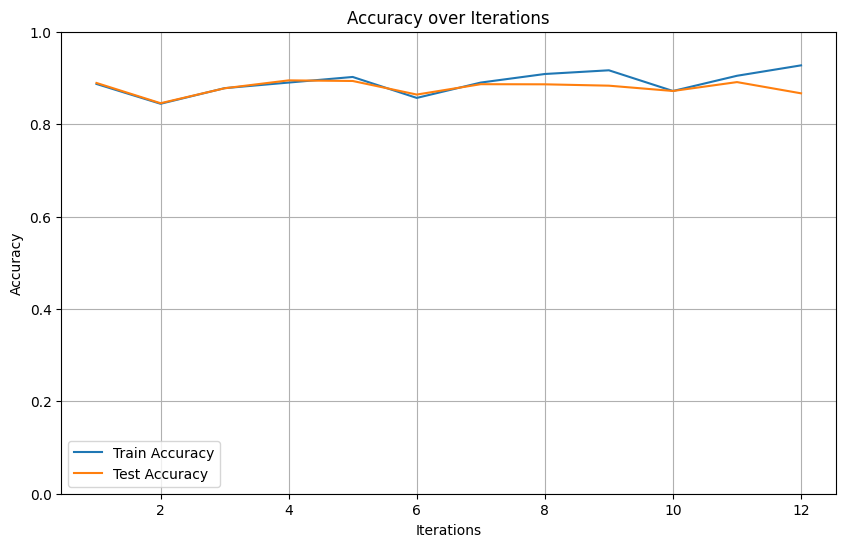

In [15]:
def train_and_evaluate_model_with_params(ClassifierID3, param_dict, train_data_transformed, mwra_train, test_data_transformed, mwra_test):
    best_model = None
    best_accuracy = 0
    best_params = None
    train_accuracies = []
    test_accuracies = []

    keys, values = zip(*param_dict.items())
    param_combinations = [dict(zip(keys, v)) for v in product(*values)]

    for i, params in enumerate(param_combinations):
        classifier = ClassifierID3(**params)
        classifier.fit(train_data_transformed, mwra_train)
        train_pred = classifier.predict(train_data_transformed)
        test_pred = classifier.predict(test_data_transformed)
        train_accuracy = accuracy_score(mwra_train, train_pred)
        test_accuracy = accuracy_score(mwra_test, test_pred)

        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

        print(f"Iteration {i+1}:")
        print(f"Parameters: {params}")
        print(f"Train Accuracy: {train_accuracy}")
        print(f"Test Accuracy: {test_accuracy}")

        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            best_model = classifier
            best_params = params

    print(f"Best Parameters: {best_params}")
    print(f"Best Accuracy: {best_accuracy}")

    # Побудова графіку
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, label='Test Accuracy')
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.title('Accuracy over Iterations')
    plt.legend()
    plt.grid(True)
    plt.show()

    return best_model, best_accuracy

# Приклад використання функції
param_dict = {
    'intervals_number': [2, 3, 4],
    'max_depth': [6, 3, 5, 7]
}

best_model, best_accuracy = train_and_evaluate_model_with_params(ClassifierID3, param_dict, train_data_transformed, mwra_train, test_data_transformed, mwra_test)


## Decision Tree Classifier

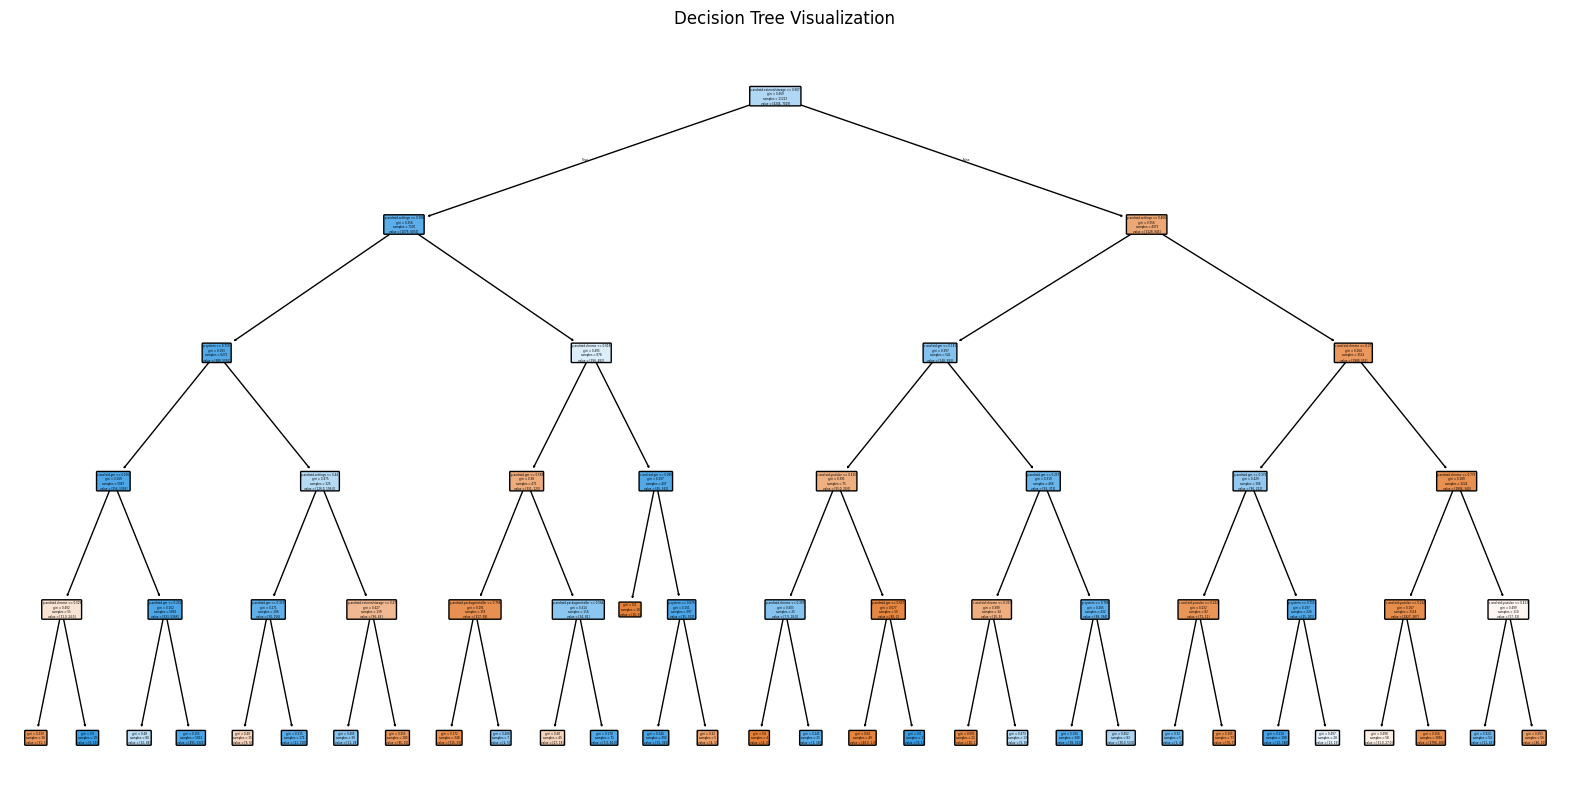

Decision Tree - Train Accuracy: 0.9026998128842555
Decision Tree - Test Accuracy: 0.9040619989310529
Decision Tree - Test Precision: 0.9069192751235585
Decision Tree - Test Recall: 0.9430406852248394


In [30]:
from sklearn.tree import DecisionTreeClassifier, plot_tree


tree_classifier = DecisionTreeClassifier(max_depth=5, random_state=42)
tree_classifier.fit(train_data_transformed, mwra_train)

plt.figure(figsize=(20, 10))
plot_tree(
    tree_classifier, 
    feature_names=train_data.columns,  
    filled=True,  
    rounded=True  
)
plt.title("Decision Tree Visualization")
plt.show()

#Make predictions using the transformed data
tree_train_pred = tree_classifier.predict(train_data_transformed)
tree_test_pred = tree_classifier.predict(test_data_transformed)

tree_train_accuracy = accuracy_score(mwra_train, tree_train_pred)
tree_test_accuracy = accuracy_score(mwra_test, tree_test_pred)
tree_test_precision = precision_score(mwra_test, tree_test_pred, average="binary")
tree_test_recall = recall_score(mwra_test, tree_test_pred, average="binary")

print(f"Decision Tree - Train Accuracy: {tree_train_accuracy}")
print(f"Decision Tree - Test Accuracy: {tree_test_accuracy}")
print(f"Decision Tree - Test Precision: {tree_test_precision}")
print(f"Decision Tree - Test Recall: {tree_test_recall}")


Results decription: 

## Logistic Regression - log-linear classifier

In [40]:
from sklearn.svm import SVC

logistic_classifier = SVC(kernel='linear', random_state=42)
logistic_classifier.fit(train_data_transformed, mwra_train)

logistic_train_pred = logistic_classifier.predict(train_data_transformed)
logistic_test_pred = logistic_classifier.predict(test_data_transformed)

logistic_train_accuracy = accuracy_score(mwra_train, logistic_train_pred)
logistic_test_accuracy = accuracy_score(mwra_test, logistic_test_pred)
logistic_test_precision = precision_score(mwra_test, logistic_test_pred, average="binary")
logistic_test_recall = recall_score(mwra_test, logistic_test_pred, average="binary")
print(f"SVC - Train Accuracy: {logistic_train_accuracy}")
print(f"SVC - Test Accuracy: {logistic_test_accuracy}")
print(f"SVC - Test Precision: {logistic_test_precision}")
print(f"SVC - Test Recall: {logistic_test_recall}")

d:\python\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC - Train Accuracy: 0.9133921411387329
SVC - Test Accuracy: 0.9160876536611438
SVC - Test Precision: 0.921217173822426
SVC - Test Recall: 0.9464668094218416


## KNeighborsClassifier

In [41]:
from sklearn.neighbors import KNeighborsClassifier
logistic_classifier = KNeighborsClassifier(n_neighbors=5)
logistic_classifier.fit(train_data_transformed, mwra_train)

logistic_train_pred = logistic_classifier.predict(train_data_transformed)
logistic_test_pred = logistic_classifier.predict(test_data_transformed)

logistic_train_accuracy = accuracy_score(mwra_train, logistic_train_pred)
logistic_test_accuracy = accuracy_score(mwra_test, logistic_test_pred)
logistic_test_precision = precision_score(mwra_test, logistic_test_pred, average="binary")
logistic_test_recall = recall_score(mwra_test, logistic_test_pred, average="binary")
print(f"SVC - Train Accuracy: {logistic_train_accuracy}")
print(f"SVC - Test Accuracy: {logistic_test_accuracy}")
print(f"SVC - Test Precision: {logistic_test_precision}")
print(f"SVC - Test Recall: {logistic_test_recall}")

d:\python\lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


SVC - Train Accuracy: 0.925242804954112
SVC - Test Accuracy: 0.9251737039016569
SVC - Test Precision: 0.9251137774100124
SVC - Test Recall: 0.9576017130620985


## Random forest classifier

In [37]:
from sklearn.ensemble import RandomForestClassifier

tree_classifier = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
tree_classifier.fit(train_data_transformed, mwra_train)

#Make predictions using the transformed data
tree_train_pred = tree_classifier.predict(train_data_transformed)
tree_test_pred = tree_classifier.predict(test_data_transformed)

tree_train_accuracy = accuracy_score(mwra_train, tree_train_pred)
tree_test_accuracy = accuracy_score(mwra_test, tree_test_pred)
tree_test_precision = precision_score(mwra_test, tree_test_pred, average="binary")
tree_test_recall = recall_score(mwra_test, tree_test_pred, average="binary")

print(f"RandomForestClassifier Tree - Train Accuracy: {tree_train_accuracy}")
print(f"RandomForestClassifier Tree - Test Accuracy: {tree_test_accuracy}")
print(f"RandomForestClassifier Tree - Test Precision: {tree_test_precision}")
print(f"RandomForestClassifier Tree - Test Recall: {tree_test_recall}")

d:\python\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier Tree - Train Accuracy: 0.917045353292346
RandomForestClassifier Tree - Test Accuracy: 0.9190272581507215
RandomForestClassifier Tree - Test Precision: 0.9170771756978654
RandomForestClassifier Tree - Test Recall: 0.956745182012848
